In [2]:
import pyspark.sql.functions as F
from pyspark.sql.types import *
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
%matplotlib inline

spark = SparkSession.builder.appName('Spark').getOrCreate()


In [3]:
#   CARREGAR E CONVERTER TIPO COLUNA
schema = StructType([
    StructField('id_candidate_seq', StringType(), True),
    StructField('id_candidate_num', IntegerType(), True),
    StructField('cat_candidate_name', StringType(), True),
    StructField('cat_state', StringType(), True),
    StructField('cat_party', StringType(), True),
    StructField('cat_coalition', StringType(), True),
    StructField('cat_composition', StringType(), True),
    StructField('cat_eletion_result', StringType(), True),
    StructField('num_turn', IntegerType(), True),
    StructField('num_votes', IntegerType(), True)
])
df_votacao_brasil_english = spark.read.format('csv').schema(schema).option('header', 'true').option('delimiter', ',').\
    load('votacao_brasil_english.csv')
# df_votacao_brasil_english.show()

schema2 = StructType([
    StructField('Cd_Eleio', StringType(), True),
    StructField('Desc_Eleio', StringType(), True),
    StructField('Data_e_hora', StringType(), True),
    StructField('CNPJ_Prestador_Conta', StringType(), True),
    StructField('Sequencial_Candidato', StringType(), True),
    StructField('UF', StringType(), True),
    StructField('Sigla__Partido', StringType(), True),
    StructField('Numero_candidato', IntegerType(), True),
    StructField('Cargo', StringType(), True),
    StructField('Nome_candidato', StringType(), True),
    StructField('CPF_do_candidato', StringType(), True),
    StructField('Numero_Recibo_Eleitoral', StringType(), True),
    StructField('Numero_do_documento', StringType(), True),
    StructField('CPF/CNPJ_do_doador', StringType(), True),
    StructField('Nome_do_doador', StringType(), True),
    StructField('Nome_do_doador_(Receita_Federal)', StringType(), True),
    StructField('Sigla_UE_doador', StringType(), True),
    StructField('Nmero_partido_doador', StringType(), True),
    StructField('Nmero_candidato_doador', StringType(), True),
    StructField('Cod_setor_econmico_do_doador', StringType(), True),
    StructField('Setor_econmico_do_doador', StringType(), True),
    StructField('Data_da_receita', StringType(), True),
    StructField('Valor_receita', StringType(), True),
    StructField('Tipo_receita', StringType(), True),
    StructField('Fonte_recurso', StringType(), True),
    StructField('Especie_recurso', StringType(), True),
    StructField('Descricao_da_receita', StringType(), True),
    StructField('CPF/CNPJ_do_doador_originrio', StringType(), True),
    StructField('Nome_do_doador_originrio', StringType(), True),
    StructField('Tipo_doador_originrio', StringType(), True),
    StructField('Setor_econmico_do_doador_originrio', StringType(), True),
    StructField('Nome_do_doador_originrio_(Receita_Federal)', StringType(), True),
])
df_receitas_partidos_2014_brasil = spark.read.format('csv').schema(schema2).option('header', 'true').option('delimiter', ';').\
    load('receitas_partidos_2014_brasil.txt')


In [4]:
#   AGRUPAR SOMA DE VOTOS POR CANDIDATO E TURNO
df_soma_votos = df_votacao_brasil_english.groupBy(df_votacao_brasil_english.id_candidate_num, df_votacao_brasil_english.num_turn).agg(F.sum(df_votacao_brasil_english.num_votes).alias('num_votes'))
df_soma_votos.show()

+----------------+--------+---------+
|id_candidate_num|num_turn|num_votes|
+----------------+--------+---------+
|              15|       1|       95|
|             400|       1|     2605|
|              45|       1|   116948|
|              45|       2|   186658|
|           12456|       1|      172|
|            5555|       1|   218756|
+----------------+--------+---------+



In [5]:
#   PEGAR NOME DO CANDIDATO, CARGO
df_join_nome_cargo = df_soma_votos.join(df_receitas_partidos_2014_brasil, df_soma_votos.id_candidate_num == df_receitas_partidos_2014_brasil.Numero_candidato).select(['Nome_candidato', 'id_candidate_num', 'Sigla__Partido', 'num_turn', 'num_votes']).distinct()
df_join_nome_cargo.show()


+--------------------+----------------+--------------+--------+---------+
|      Nome_candidato|id_candidate_num|Sigla__Partido|num_turn|num_votes|
+--------------------+----------------+--------------+--------+---------+
|ANTONIO JOSE DE M...|              15|          PMDB|       1|       95|
|MARCONI FERREIRA ...|              45|          PSDB|       2|   186658|
|JOSE MARIO SCHREINER|            5555|           PSD|       1|   218756|
|MARCONI FERREIRA ...|              45|          PSDB|       1|   116948|
|WILSON NUNES MARTINS|             400|           PSB|       1|     2605|
+--------------------+----------------+--------------+--------+---------+



In [6]:
#   LISTA DE CANDIDATOS PT-1
df_join_nome_cargo.select(['Nome_candidato', 'id_candidate_num', 'Sigla__Partido']).distinct().show()


+--------------------+----------------+--------------+
|      Nome_candidato|id_candidate_num|Sigla__Partido|
+--------------------+----------------+--------------+
|JOSE MARIO SCHREINER|            5555|           PSD|
|ANTONIO JOSE DE M...|              15|          PMDB|
|WILSON NUNES MARTINS|             400|           PSB|
|MARCONI FERREIRA ...|              45|          PSDB|
+--------------------+----------------+--------------+



In [7]:
# VOTACOES DO PRIMEIRO E SEGUNDO TURNO
df_join_nome_cargo.select(['Nome_candidato', 'id_candidate_num', 'Sigla__Partido', 'num_votes']).where(df_join_nome_cargo.num_turn == 1).show()
df_join_nome_cargo.select(['Nome_candidato', 'id_candidate_num', 'Sigla__Partido', 'num_votes']).where(df_join_nome_cargo.num_turn == 2).show()


+--------------------+----------------+--------------+---------+
|      Nome_candidato|id_candidate_num|Sigla__Partido|num_votes|
+--------------------+----------------+--------------+---------+
|ANTONIO JOSE DE M...|              15|          PMDB|       95|
|JOSE MARIO SCHREINER|            5555|           PSD|   218756|
|MARCONI FERREIRA ...|              45|          PSDB|   116948|
|WILSON NUNES MARTINS|             400|           PSB|     2605|
+--------------------+----------------+--------------+---------+

+--------------------+----------------+--------------+---------+
|      Nome_candidato|id_candidate_num|Sigla__Partido|num_votes|
+--------------------+----------------+--------------+---------+
|MARCONI FERREIRA ...|              45|          PSDB|   186658|
+--------------------+----------------+--------------+---------+



In [8]:
# SEPARAR CANDIDATOS POR ESTADO
df_votacao_brasil_english.groupBy(df_votacao_brasil_english.id_candidate_num, df_votacao_brasil_english.num_turn, df_votacao_brasil_english.cat_state).agg(F.sum(df_votacao_brasil_english.num_votes).alias('num_votes')).show()


+----------------+--------+---------+---------+
|id_candidate_num|num_turn|cat_state|num_votes|
+----------------+--------+---------+---------+
|              45|       1|       SC|   116948|
|              45|       2|       SC|   186658|
|           12456|       1|       RS|      172|
|             400|       1|       PR|     2605|
|              15|       1|       SC|       47|
|              15|       1|       PR|       48|
|            5555|       1|       RS|   218756|
+----------------+--------+---------+---------+



In [9]:
# SEPARAR CANDIDATOS RS
df_rs = df_votacao_brasil_english.groupBy(df_votacao_brasil_english.id_candidate_num, df_votacao_brasil_english.num_turn, df_votacao_brasil_english.cat_state).agg(F.sum(df_votacao_brasil_english.num_votes).alias('num_votes')).where(df_votacao_brasil_english.cat_state == 'RS')
total_rs = df_rs.agg(F.sum(df_rs.num_votes).alias('num_votes')).first().num_votes
df_rs.show()

+----------------+--------+---------+---------+
|id_candidate_num|num_turn|cat_state|num_votes|
+----------------+--------+---------+---------+
|           12456|       1|       RS|      172|
|            5555|       1|       RS|   218756|
+----------------+--------+---------+---------+



In [10]:
# ADICIONAR COLUNA DE PERCENTUAL
df_percentual = df_rs.withColumn('Percentual', F.lit((df_rs.num_votes * 100) / total_rs))



In [11]:
df_percentual.show()

+----------------+--------+---------+---------+-------------------+
|id_candidate_num|num_turn|cat_state|num_votes|         Percentual|
+----------------+--------+---------+---------+-------------------+
|           12456|       1|       RS|      172|0.07856464225681503|
|            5555|       1|       RS|   218756|  99.92143535774318|
+----------------+--------+---------+---------+-------------------+



In [12]:
df_percentual.printSchema()

root
 |-- id_candidate_num: integer (nullable = true)
 |-- num_turn: integer (nullable = true)
 |-- cat_state: string (nullable = true)
 |-- num_votes: long (nullable = true)
 |-- Percentual: double (nullable = true)



In [13]:
# FUNCAO DE ROUND
udf_funcao = F.udf(lambda  x : round(x, 2), DoubleType())
df_funcao_round = df_percentual.select(
    df_percentual.id_candidate_num,
    df_percentual.num_turn,
    df_percentual.cat_state,
    df_percentual.num_votes,
    udf_funcao(df_percentual.Percentual).alias('Percentual')
)


In [14]:
df_funcao_round.show()

+----------------+--------+---------+---------+----------+
|id_candidate_num|num_turn|cat_state|num_votes|Percentual|
+----------------+--------+---------+---------+----------+
|           12456|       1|       RS|      172|      0.08|
|            5555|       1|       RS|   218756|     99.92|
+----------------+--------+---------+---------+----------+



Text(0.5, 1.0, 'Titulo')

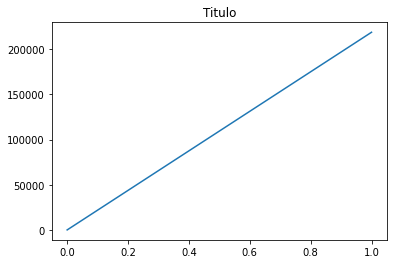

In [19]:
plt.plot([1,total_rs])
plt.title('Titulo')

Text(0.5, 1.0, 'Titulo')

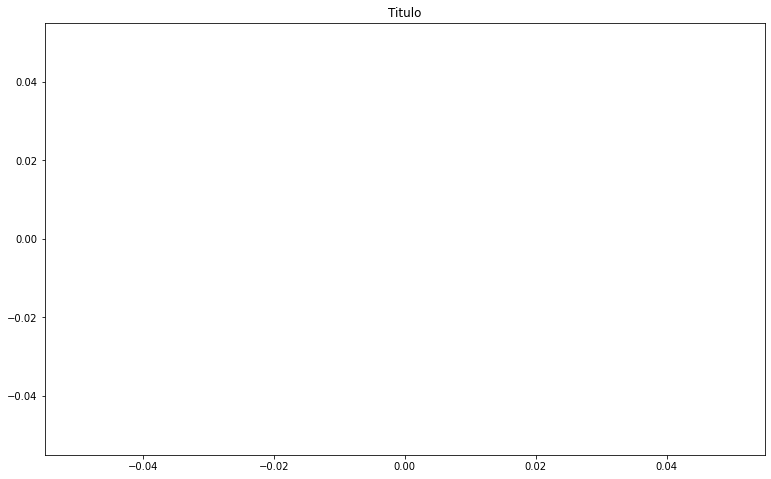

In [21]:
fig = plt.figure(figsize=(10,6))
eixo = fig.add_axes([0,0,1,1])
eixo.plot()
eixo.set_title('Titulo')